In [1]:
import os
import boto3
import re
import copy
import time
from time import gmtime, strftime
from sagemaker import get_execution_role

role = get_execution_role()

region = boto3.Session().region_name

bucket='sagemakernflstats1' # Replace with your s3 bucket name
prefix = 'sagemaker/xgboost-mnist' # Used as part of the path in the bucket where you store data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket) # The URL to access the bucket

In [2]:
import pandas as pd
import numpy as np

In [3]:
pass_df = pd.read_csv("https://sagemakernflstats1.s3.amazonaws.com/nflstatistics/Career_Stats_Passing.csv")

In [4]:
pass_df.head()

,Player Id,Name,Position,Year,Team,Games Played,Passes Attempted,Passes Completed,Completion Percentage,Pass Attempts Per Game,...,TD Passes,Percentage of TDs per Attempts,Ints,Int Rate,Longest Pass,Passes Longer than 20 Yards,Passes Longer than 40 Yards,Sacks,Sacked Yards Lost,Passer Rating
0,tomfarris/2513861,"Farris, Tom",NaN,1948,Chicago Rockets,0,--,--,--,0.0,...,--,--,--,--,--,--,--,--,--,0.0
1,tomfarris/2513861,"Farris, Tom",NaN,1947,Chicago Bears,9,2,0,0.0,0.2,...,0,0.0,0,0.0,--,0,0,0,0,39.6
2,tomfarris/2513861,"Farris, Tom",NaN,1946,Chicago Bears,11,21,8,38.1,1.9,...,1,4.8,2,9.5,--,0,0,0,0,31.5
3,billdemory/2512778,"Demory, Bill",NaN,1974,New York Jets,1,--,--,--,0.0,...,--,--,--,--,--,--,--,--,--,0.0
4,billdemory/2512778,"Demory, Bill",NaN,1973,New York Jets,6,39,12,30.8,6.5,...,2,5.1,8,20.5,--,0,0,8,73,22.2


In [5]:
pass_df['Position'].isnull().sum()

7414

In [6]:
pass_df.isnull().sum()

Player Id                            0
Name                                 0
Position                          7414
Year                                 0
Team                                 0
Games Played                         0
Passes Attempted                     0
Passes Completed                     0
Completion Percentage                0
Pass Attempts Per Game               0
Passing Yards                        0
Passing Yards Per Attempt            0
Passing Yards Per Game               0
TD Passes                            0
Percentage of TDs per Attempts       0
Ints                                 0
Int Rate                             0
Longest Pass                         0
Passes Longer than 20 Yards          0
Passes Longer than 40 Yards          0
Sacks                                0
Sacked Yards Lost                    0
Passer Rating                        0
dtype: int64

In [7]:
df = pass_df[pass_df['Games Played'] != 0]
df.head()

,Player Id,Name,Position,Year,Team,Games Played,Passes Attempted,Passes Completed,Completion Percentage,Pass Attempts Per Game,...,TD Passes,Percentage of TDs per Attempts,Ints,Int Rate,Longest Pass,Passes Longer than 20 Yards,Passes Longer than 40 Yards,Sacks,Sacked Yards Lost,Passer Rating
1,tomfarris/2513861,"Farris, Tom",NaN,1947,Chicago Bears,9,2,0,0.0,0.2,...,0,0.0,0,0.0,--,0,0,0,0,39.6
2,tomfarris/2513861,"Farris, Tom",NaN,1946,Chicago Bears,11,21,8,38.1,1.9,...,1,4.8,2,9.5,--,0,0,0,0,31.5
3,billdemory/2512778,"Demory, Bill",NaN,1974,New York Jets,1,--,--,--,0.0,...,--,--,--,--,--,--,--,--,--,0.0
4,billdemory/2512778,"Demory, Bill",NaN,1973,New York Jets,6,39,12,30.8,6.5,...,2,5.1,8,20.5,--,0,0,8,73,22.2
5,breezyreid/2523928,"Reid, Breezy",NaN,1956,Green Bay Packers,7,--,--,--,0.0,...,--,--,--,--,--,--,--,--,--,0.0


In [8]:
column_names = pass_df.columns
print(column_names)

Index(['Player Id', 'Name', 'Position', 'Year', 'Team', 'Games Played',
       'Passes Attempted', 'Passes Completed', 'Completion Percentage',
       'Pass Attempts Per Game', 'Passing Yards', 'Passing Yards Per Attempt',
       'Passing Yards Per Game', 'TD Passes', 'Percentage of TDs per Attempts',
       'Ints', 'Int Rate', 'Longest Pass', 'Passes Longer than 20 Yards',
       'Passes Longer than 40 Yards', 'Sacks', 'Sacked Yards Lost',
       'Passer Rating'],
      dtype='object')


In [9]:
df = df[['Player Id', 'Name', 'Games Played', 'Completion Percentage',
       'Pass Attempts Per Game', 'Passing Yards Per Attempt',
       'Passing Yards Per Game', 'Percentage of TDs per Attempts',
         'Int Rate','Passer Rating']]

In [10]:
df.head()

,Player Id,Name,Games Played,Completion Percentage,Pass Attempts Per Game,Passing Yards Per Attempt,Passing Yards Per Game,Percentage of TDs per Attempts,Int Rate,Passer Rating
1,tomfarris/2513861,"Farris, Tom",9,0.0,0.2,0.0,0.0,0.0,0.0,39.6
2,tomfarris/2513861,"Farris, Tom",11,38.1,1.9,5.1,9.8,4.8,9.5,31.5
3,billdemory/2512778,"Demory, Bill",1,--,0.0,--,--,--,--,0.0
4,billdemory/2512778,"Demory, Bill",6,30.8,6.5,4.1,26.5,5.1,20.5,22.2
5,breezyreid/2523928,"Reid, Breezy",7,--,0.0,--,--,--,--,0.0


In [11]:
df.head()

,Player Id,Name,Games Played,Completion Percentage,Pass Attempts Per Game,Passing Yards Per Attempt,Passing Yards Per Game,Percentage of TDs per Attempts,Int Rate,Passer Rating
1,tomfarris/2513861,"Farris, Tom",9,0.0,0.2,0.0,0.0,0.0,0.0,39.6
2,tomfarris/2513861,"Farris, Tom",11,38.1,1.9,5.1,9.8,4.8,9.5,31.5
3,billdemory/2512778,"Demory, Bill",1,--,0.0,--,--,--,--,0.0
4,billdemory/2512778,"Demory, Bill",6,30.8,6.5,4.1,26.5,5.1,20.5,22.2
5,breezyreid/2523928,"Reid, Breezy",7,--,0.0,--,--,--,--,0.0


In [12]:
ext = df['Player Id'].str.extract('(\d+)').astype(int)
ext.head()

,0
1,2513861
2,2513861
3,2512778
4,2512778
5,2523928


In [13]:
df['Player Id'] = ext

In [14]:
df.head()

,Player Id,Name,Games Played,Completion Percentage,Pass Attempts Per Game,Passing Yards Per Attempt,Passing Yards Per Game,Percentage of TDs per Attempts,Int Rate,Passer Rating
1,2513861,"Farris, Tom",9,0.0,0.2,0.0,0.0,0.0,0.0,39.6
2,2513861,"Farris, Tom",11,38.1,1.9,5.1,9.8,4.8,9.5,31.5
3,2512778,"Demory, Bill",1,--,0.0,--,--,--,--,0.0
4,2512778,"Demory, Bill",6,30.8,6.5,4.1,26.5,5.1,20.5,22.2
5,2523928,"Reid, Breezy",7,--,0.0,--,--,--,--,0.0


In [15]:
df = df[df.ne('--').all(1)]
df.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,Player Id,Name,Games Played,Completion Percentage,Pass Attempts Per Game,Passing Yards Per Attempt,Passing Yards Per Game,Percentage of TDs per Attempts,Int Rate,Passer Rating
1,2513861,"Farris, Tom",9,0.0,0.2,0.0,0.0,0.0,0.0,39.6
2,2513861,"Farris, Tom",11,38.1,1.9,5.1,9.8,4.8,9.5,31.5
4,2512778,"Demory, Bill",6,30.8,6.5,4.1,26.5,5.1,20.5,22.2
10,2523928,"Reid, Breezy",12,0.0,0.1,0.0,0.0,0.0,0.0,39.6
12,2518652,"Knolla, Johnny",7,0.0,0.1,0.0,0.0,0.0,0.0,39.6


In [16]:
df.isnull().sum()

Player Id                         0
Name                              0
Games Played                      0
Completion Percentage             0
Pass Attempts Per Game            0
Passing Yards Per Attempt         0
Passing Yards Per Game            0
Percentage of TDs per Attempts    0
Int Rate                          0
Passer Rating                     0
dtype: int64

In [17]:
print (df.dtypes)

Player Id                           int64
Name                               object
Games Played                        int64
Completion Percentage              object
Pass Attempts Per Game            float64
Passing Yards Per Attempt          object
Passing Yards Per Game             object
Percentage of TDs per Attempts     object
Int Rate                           object
Passer Rating                     float64
dtype: object


In [18]:
df['Completion Percentage'] = df['Completion Percentage'].astype(str).astype('float32')
df['Passing Yards Per Attempt'] = df['Passing Yards Per Attempt'].astype(str).astype('float32')
df['Passing Yards Per Game'] = df['Passing Yards Per Game'].astype(str).astype('float32')
df['Percentage of TDs per Attempts'] = df['Percentage of TDs per Attempts'].astype(str).astype('float32')
df['Int Rate'] = df['Int Rate'].astype(str).astype('float32')

In [19]:
print (df.dtypes)

Player Id                           int64
Name                               object
Games Played                        int64
Completion Percentage             float32
Pass Attempts Per Game            float64
Passing Yards Per Attempt         float32
Passing Yards Per Game            float32
Percentage of TDs per Attempts    float32
Int Rate                          float32
Passer Rating                     float64
dtype: object


In [20]:
df = df.groupby(['Player Id', 'Name']).mean().reset_index()

In [21]:
df.head()

,Player Id,Name,Games Played,Completion Percentage,Pass Attempts Per Game,Passing Yards Per Attempt,Passing Yards Per Game,Percentage of TDs per Attempts,Int Rate,Passer Rating
0,234,"Forte, Matt",12.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,39.600000
1,252,"Henne, Chad",9.142857,57.985714,26.742857,6.571429,179.071426,2.771429,2.614286,76.142857
2,262,"Johnson, Chris",16.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,39.600000
3,264,"Johnson, Josh",8.666667,63.566666,8.766667,6.400000,50.533333,2.000000,4.000000,69.033333
4,284,"McFadden, Darren",13.750000,25.000000,0.100000,4.000000,0.400000,25.000000,0.000000,69.275000


In [22]:
#no need to split data into training and testing because this will be using an unsupervised training

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

mns = MinMaxScaler()
df[['Games Played', 'Completion Percentage', 'Pass Attempts Per Game', 'Passing Yards Per Attempt','Passing Yards Per Game', 'Percentage of TDs per Attempts', 'Int Rate', 'Passer Rating']] = mns.fit_transform(df[['Games Played', 
                                                   'Completion Percentage',
                                                   'Pass Attempts Per Game',
                                                   'Passing Yards Per Attempt',
                                                   'Passing Yards Per Game',
                                                   'Percentage of TDs per Attempts',
                                                   'Int Rate',
                                                   'Passer Rating'
                                                  ]])
df.index = df['Name']
df.drop('Player Id', axis = 1, inplace = True)
df.drop('Name', axis = 1, inplace = True)
df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Games Played,Completion Percentage,Pass Attempts Per Game,Passing Yards Per Attempt,Passing Yards Per Game,Percentage of TDs per Attempts,Int Rate,Passer Rating
Name,,,,,,,,
"Forte, Matt",0.733333,0.000000,4.336809e-19,0.137500,0.005719,0.000000,0.000000,0.250158
"Henne, Chad",0.542857,0.579857,6.942764e-01,0.219643,0.645803,0.027714,0.026143,0.481004
"Johnson, Chris",1.000000,0.000000,4.336809e-19,0.137500,0.005719,0.000000,0.000000,0.250158
"Johnson, Josh",0.511111,0.635667,2.258415e-01,0.217500,0.186349,0.020000,0.040000,0.436092
"McFadden, Darren",0.850000,0.250000,4.336809e-19,0.187500,0.007149,0.250000,0.000000,0.437618
"Ryan, Matt",0.985185,0.646111,9.253710e-01,0.230833,0.951919,0.047556,0.022556,0.589949
"Flynn, Matt",0.358333,0.572375,2.456026e-01,0.214063,0.253519,0.029750,0.033750,0.454675
"O'Connell, Kevin",0.066667,0.667000,7.557003e-02,0.185000,0.046825,0.000000,0.000000,0.464940
"Flacco, Joe",0.955556,0.614889,9.007600e-01,0.223889,0.857473,0.038667,0.024667,0.534920


In [24]:
df.describe()

,Games Played,Completion Percentage,Pass Attempts Per Game,Passing Yards Per Attempt,Passing Yards Per Game,Percentage of TDs per Attempts,Int Rate,Passer Rating
count,1323.000000,1323.000000,1.323000e+03,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000
mean,0.598509,0.407375,1.494077e-01,0.217824,0.137565,0.069289,0.101997,0.372462
std,0.299729,0.308315,2.287052e-01,0.103701,0.212788,0.187840,0.205855,0.220048
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.383333,0.121500,4.336809e-19,0.142813,0.006077,0.000000,0.000000,0.250158
50%,0.640000,0.442250,1.563518e-02,0.204167,0.016621,0.000000,0.029000,0.344915
75%,0.866667,0.573667,2.505972e-01,0.228750,0.199008,0.041667,0.091500,0.500316
max,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
from sagemaker import PCA
bucket_name='sagemakernflstats1'
num_components=7

pca_SM = PCA(role=role,
          train_instance_count=1,
          train_instance_type='ml.c4.xlarge',
          output_path='s3://'+ bucket_name +'/passingstat/',
            num_components=num_components)

In [26]:
train_data = df.values.astype('float32')

In [27]:
%%time
pca_SM.fit(pca_SM.record_set(train_data))
#already ran and have a training done -> fetch from jobs

2019-06-20 15:43:03 Starting - Starting the training job...
2019-06-20 15:43:06 Starting - Launching requested ML instances......
2019-06-20 15:44:11 Starting - Preparing the instances for training.........
2019-06-20 15:46:01 Downloading - Downloading input data
2019-06-20 15:46:01 Training - Training image download completed. Training in progress.
2019-06-20 15:46:01 Uploading - Uploading generated training model
Docker entrypoint called with argument(s): train
[06/20/2019 15:45:58 INFO 140056259372864] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[06/20/2019 15:45:58 INFO 140056259372864] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'8', u


2019-06-20 15:46:07 Completed - Training job completed
Billable seconds: 33
CPU times: user 468 ms, sys: 26.6 ms, total: 495 ms
Wall time: 3min 42s


In [28]:
job_name='pca-2019-06-20-15-43-03-130'
model_key = "passingstat/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

2304

In [31]:
!pip install mxnet

    100% |████████████████████████████████| 28.4MB 1.7MB/s eta 0:00:01
    100% |████████████████████████████████| 13.8MB 5.3MB/s eta 0:00:01
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [32]:
import mxnet as mx
pca_model_params = mx.ndarray.load('model_algo-1')

In [33]:
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [34]:
s.iloc[2:,:].apply(lambda x: x*x).sum()/s.apply(lambda x: x*x).sum()
#top 5 component accounts for 98% of the total variance in our dataset

0    0.974523
dtype: float32

In [35]:
s_5=s.iloc[2:,:]
v_5=v.iloc[:,2:]
v_5.columns=[0,1,2,3,4]
#take only the 5 largest components from our original matrix

In [36]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.style.use('ggplot')
%matplotlib inline

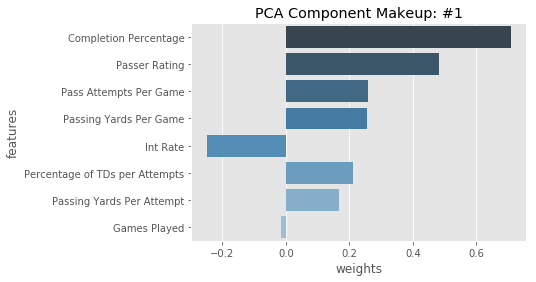

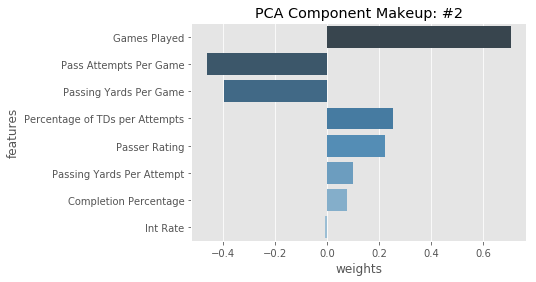

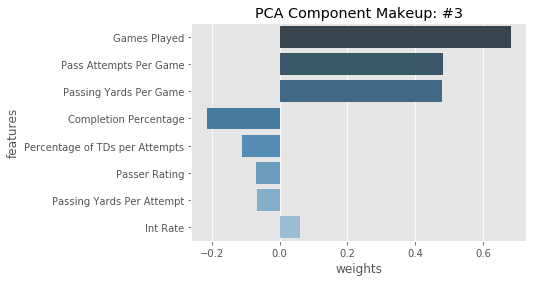

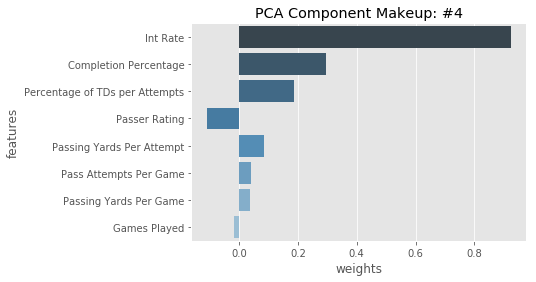

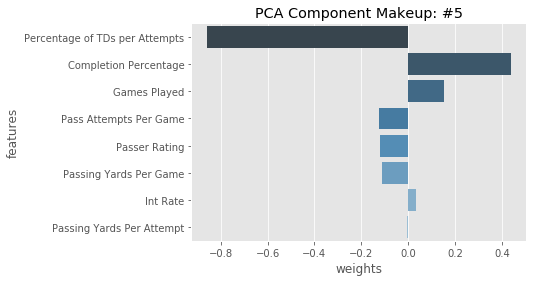

In [37]:
for i in range(1,6):
    first_comp = v_5[5-i]
    comps = pd.DataFrame(list(zip(first_comp, df.columns)), columns=['weights', 'features'])
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    ax=sns.barplot(data=comps.sort_values('abs_weights', ascending=False).head(10), x="weights", y="features", palette="Blues_d")
    ax.set_title("PCA Component Makeup: #" + str(i))
    plt.show()
#display all 5 components and their weights

In [38]:
#PCA_list=['comp_1', 'comp_2', 'comp_3', 'comp_4', 'comp_5']

PCA_list=["Completion Percentage/Passer Rating", "Games Played/TDs per attempt", "Games Played/Pass attempt per game/pass yard per game", \
         "Int Rate/Completeion Percentage", "Completion Percentage/Games Played"]

In [39]:
%%time
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')
#deploy an endpoint for the pca
#MAKE SURE TO DELETE ENDPOINTS AFTER

--------------------------------------------------------------------------------------------------------------!CPU times: user 557 ms, sys: 30.9 ms, total: 588 ms
Wall time: 9min 17s


In [40]:
df.shape

(1323, 8)

In [41]:
%%time
result = pca_predictor.predict(train_data)
df_transformed=pd.DataFrame()

for a in result:
    b=a.label['projection'].float32_tensor.values
    df_transformed=df_transformed.append([list(b)])


CPU times: user 2.23 s, sys: 8.03 ms, total: 2.24 s
Wall time: 2.43 s


In [42]:
df_transformed.shape

(1323, 7)

In [43]:
df_transformed.index=df.index
df_transformed=df_transformed.iloc[:,2:]
df_transformed.columns=PCA_list

In [44]:
df_transformed.head()

,Completion Percentage/Passer Rating,Games Played/TDs per attempt,Games Played/Pass attempt per game/pass yard per game,Int Rate/Completeion Percentage,Completion Percentage/Games Played
Name,,,,,
"Forte, Matt",-0.053607,-0.234655,0.059356,0.134051,-0.424423
"Henne, Chad",-0.037843,0.003604,0.424174,-0.466646,0.455734
"Johnson, Chris",-0.013115,-0.239507,0.241214,0.322314,-0.428754
"Johnson, Josh",0.104643,0.000507,-0.051182,-0.096982,0.231004
"McFadden, Darren",-0.164003,-0.132287,0.041990,0.344364,-0.097538


In [45]:
train_data = df_transformed.values.astype('float32')

In [46]:
from sagemaker import KMeans

num_clusters = 5
kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path='s3://'+ bucket_name +'/passingstat/',              
                k=num_clusters)

In [47]:
%%time
kmeans.fit(kmeans.record_set(train_data))
#create the training job for KMeans

2019-06-20 15:57:28 Starting - Starting the training job...
2019-06-20 15:57:29 Starting - Launching requested ML instances...
2019-06-20 15:58:28 Starting - Preparing the instances for training.........
2019-06-20 15:59:51 Downloading - Downloading input data..

2019-06-20 16:00:24 Training - Training image download completed. Training in progress.
2019-06-20 16:00:24 Uploading - Uploading generated training model
2019-06-20 16:00:24 Completed - Training job completed
Docker entrypoint called with argument(s): train
[06/20/2019 16:00:14 INFO 140387529873216] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local

Billable seconds: 34
CPU times: user 422 ms, sys: 17.8 ms, total: 440 ms
Wall time: 3min 12s


In [48]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')
#KMeans endpoint

---------------------------------------------------------------------------------------------------------------!CPU times: user 548 ms, sys: 50.5 ms, total: 599 ms
Wall time: 9min 22s


In [49]:
%%time
result=kmeans_predictor.predict(train_data)

CPU times: user 90 ms, sys: 0 ns, total: 90 ms
Wall time: 342 ms


In [50]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]
pd.DataFrame(cluster_labels)[0].value_counts()

1.0    486
4.0    396
2.0    200
0.0    184
3.0     57
Name: 0, dtype: int64

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


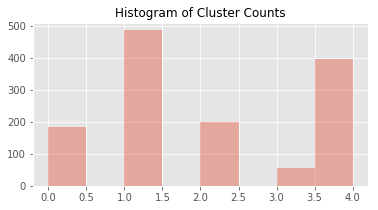

In [51]:
ax=plt.subplots(figsize=(6,3))
ax=sns.distplot(cluster_labels, kde=False)
title="Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

In [52]:
job_name='kmeans-2019-06-20-15-57-27-826'
model_key = "passingstat/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

2304

In [53]:
Kmeans_model_params = mx.ndarray.load('model_algo-1')

In [54]:
cluster_centroids=pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns=df_transformed.columns
cluster_centroids

,Completion Percentage/Passer Rating,Games Played/TDs per attempt,Games Played/Pass attempt per game/pass yard per game,Int Rate/Completeion Percentage,Completion Percentage/Games Played
0,-0.023651,0.010095,0.438076,-0.342132,0.405847
1,0.003325,-0.095764,0.044505,0.168596,-0.273176
2,0.019654,0.062682,-0.129815,0.491887,0.534990
3,0.020662,0.705775,0.189329,0.124200,-0.792763
4,-0.008078,-0.000089,-0.193784,-0.305573,0.013884


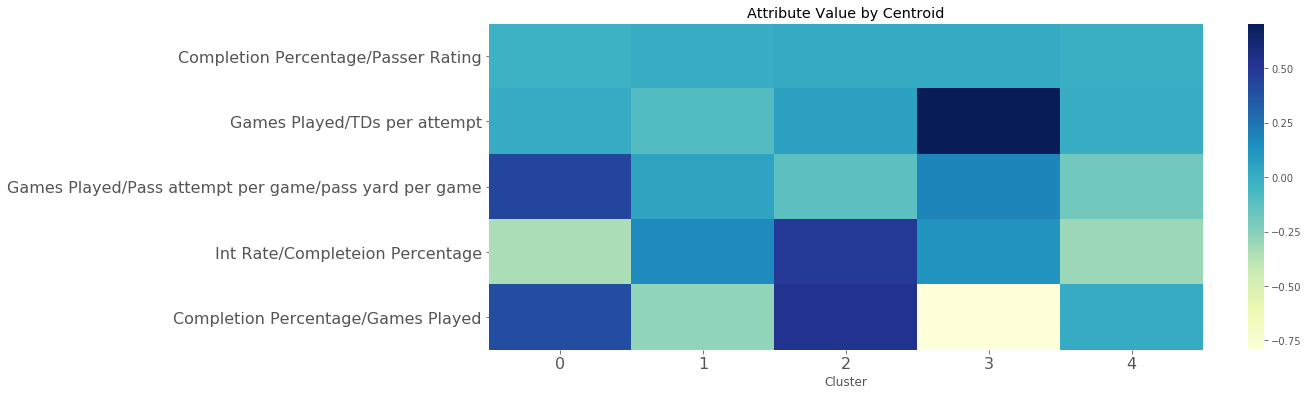

In [55]:
plt.figure(figsize = (16, 6))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

In [56]:
df_transformed['labels']=list(map(int, cluster_labels))
df_transformed.head()

,Completion Percentage/Passer Rating,Games Played/TDs per attempt,Games Played/Pass attempt per game/pass yard per game,Int Rate/Completeion Percentage,Completion Percentage/Games Played,labels
Name,,,,,,
"Forte, Matt",-0.053607,-0.234655,0.059356,0.134051,-0.424423,1
"Henne, Chad",-0.037843,0.003604,0.424174,-0.466646,0.455734,0
"Johnson, Chris",-0.013115,-0.239507,0.241214,0.322314,-0.428754,1
"Johnson, Josh",0.104643,0.000507,-0.051182,-0.096982,0.231004,4
"McFadden, Darren",-0.164003,-0.132287,0.041990,0.344364,-0.097538,1


In [57]:
cluster=df_transformed[df_transformed['labels']==1]
cluster.head(5)

,Completion Percentage/Passer Rating,Games Played/TDs per attempt,Games Played/Pass attempt per game/pass yard per game,Int Rate/Completeion Percentage,Completion Percentage/Games Played,labels
Name,,,,,,
"Forte, Matt",-0.053607,-0.234655,0.059356,0.134051,-0.424423,1
"Johnson, Chris",-0.013115,-0.239507,0.241214,0.322314,-0.428754,1
"McFadden, Darren",-0.164003,-0.132287,0.041990,0.344364,-0.097538,1
"Royal, Eddie",-0.023238,-0.238294,0.195749,0.275248,-0.427671,1
"Garcon, Pierre",-0.013115,-0.239507,0.241214,0.322314,-0.428754,1


In [58]:
print("DELETE ENDPOINTS AND ENDPOINT CONFIGS AND MODELS")

DELETE ENDPOINTS AND ENDPOINT CONFIGS AND MODELS


In [59]:
cluster

,Completion Percentage/Passer Rating,Games Played/TDs per attempt,Games Played/Pass attempt per game/pass yard per game,Int Rate/Completeion Percentage,Completion Percentage/Games Played,labels
Name,,,,,,
"Forte, Matt",-0.053607,-0.234655,0.059356,0.134051,-0.424423,1
"Johnson, Chris",-0.013115,-0.239507,0.241214,0.322314,-0.428754,1
"McFadden, Darren",-0.164003,-0.132287,0.041990,0.344364,-0.097538,1
"Royal, Eddie",-0.023238,-0.238294,0.195749,0.275248,-0.427671,1
"Garcon, Pierre",-0.013115,-0.239507,0.241214,0.322314,-0.428754,1
"Colquitt, Britton",-0.013115,-0.239507,0.241214,0.322314,-0.428754,1
"Maclin, Jeremy",-0.053607,-0.234655,0.059356,0.134051,-0.424423,1
"Scott, Bernard",-0.013115,-0.239507,0.241214,0.322314,-0.428754,1
"Alexander, Danario",-0.073853,-0.232229,-0.031573,0.039919,-0.422257,1


In [61]:
pass_df

,Player Id,Name,Position,Year,Team,Games Played,Passes Attempted,Passes Completed,Completion Percentage,Pass Attempts Per Game,...,TD Passes,Percentage of TDs per Attempts,Ints,Int Rate,Longest Pass,Passes Longer than 20 Yards,Passes Longer than 40 Yards,Sacks,Sacked Yards Lost,Passer Rating
0,tomfarris/2513861,"Farris, Tom",NaN,1948,Chicago Rockets,0,--,--,--,0.0,...,--,--,--,--,--,--,--,--,--,0.0
1,tomfarris/2513861,"Farris, Tom",NaN,1947,Chicago Bears,9,2,0,0.0,0.2,...,0,0.0,0,0.0,--,0,0,0,0,39.6
2,tomfarris/2513861,"Farris, Tom",NaN,1946,Chicago Bears,11,21,8,38.1,1.9,...,1,4.8,2,9.5,--,0,0,0,0,31.5
3,billdemory/2512778,"Demory, Bill",NaN,1974,New York Jets,1,--,--,--,0.0,...,--,--,--,--,--,--,--,--,--,0.0
4,billdemory/2512778,"Demory, Bill",NaN,1973,New York Jets,6,39,12,30.8,6.5,...,2,5.1,8,20.5,--,0,0,8,73,22.2
5,breezyreid/2523928,"Reid, Breezy",NaN,1956,Green Bay Packers,7,--,--,--,0.0,...,--,--,--,--,--,--,--,--,--,0.0
6,breezyreid/2523928,"Reid, Breezy",NaN,1955,Green Bay Packers,12,--,--,--,0.0,...,--,--,--,--,--,--,--,--,--,0.0
7,breezyreid/2523928,"Reid, Breezy",NaN,1954,Green Bay Packers,12,--,--,--,0.0,...,--,--,--,--,--,--,--,--,--,0.0
8,breezyreid/2523928,"Reid, Breezy",NaN,1953,Green Bay Packers,12,--,--,--,0.0,...,--,--,--,--,--,--,--,--,--,0.0
9,breezyreid/2523928,"Reid, Breezy",NaN,1952,Green Bay Packers,12,--,--,--,0.0,...,--,--,--,--,--,--,--,--,--,0.0
